In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -Uqq fastai roboflow timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

In [ ]:
from roboflow import Roboflow
import os, shutil

rf = Roboflow(api_key="lCKclfGJlHRGh5yd65Xz")  # Replace with your API key if needed
project = rf.workspace("drproject").project("dr-coloured")
version = project.version(8)
dataset = version.download("multiclass")

drive_target = "/content/drive/MyDrive/cap1"
src = f"/content/DR-Coloured-8"

if not os.path.exists(drive_target):
    os.makedirs(drive_target)

for f in os.listdir(src):
    shutil.move(os.path.join(src, f), drive_target)


loading Roboflow workspace...
loading Roboflow project...


In [3]:
from pathlib import Path
import pandas as pd
drive_target = "/content/drive/MyDrive/cap"
base_path = Path(drive_target)
folders = ["train", "valid", "test"]

for folder in folders:
    folder_path = base_path / folder
    csv_path = folder_path / "_classes.csv"
    if not csv_path.exists():
        print(f"❌ Missing: {csv_path}")
        continue
    df = pd.read_csv(csv_path)
    missing = [f for f in df["filename"] if not (folder_path / f).exists()]
    if missing:
        print(f"❌ {folder}: {len(missing)} missing images out of {len(df)}")
    else:
        print(f"✅ {folder}: all images present in cleaned CSV")


✅ train: all images present in cleaned CSV
✅ valid: all images present in cleaned CSV
✅ test: all images present in cleaned CSV


In [4]:
def convert_csv(path):
    df = pd.read_csv(path)
    df['labels'] = df.iloc[:, 1:].apply(lambda row: ' '.join(row.index[row == 1]), axis=1)
    return df[['filename', 'labels']]

train_df = convert_csv(f"{drive_target}/train/_classes.csv")
valid_df = convert_csv(f"{drive_target}/valid/_classes.csv")
test_df  = convert_csv(f"{drive_target}/test/_classes.csv")

train_df['filepath'] = train_df['filename'].apply(lambda x: f"{drive_target}/train/{x}")
valid_df['filepath'] = valid_df['filename'].apply(lambda x: f"{drive_target}/valid/{x}")
test_df['filepath']  = test_df['filename'].apply(lambda x: f"{drive_target}/test/{x}")


In [5]:
combined_df = pd.concat([train_df, valid_df], ignore_index=True)
valid_idx = list(range(len(train_df), len(combined_df)))


In [6]:
from fastai.vision.all import *
from fastai.callback.mixup import MixUp
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('filepath'),
    get_y=ColReader('labels'),
    splitter=IndexSplitter(valid_idx),
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(
        flip_vert=True, max_rotate=20, max_zoom=1.2,
        max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75
    )
)

dls = dblock.dataloaders(combined_df, bs=32)

learn = vision_learner(
    dls, "convnext_tiny_in22k", metrics=accuracy,
    loss_func=CrossEntropyLossFlat(label_smoothing=0.1),
    cbs=MixUp()
)

learn.fine_tune(5)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('filepath'),
    get_y=ColReader('labels'),
    splitter=IndexSplitter(valid_idx),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(
        flip_vert=True, max_rotate=20, max_zoom=1.2,
        max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75
    )
)

dls = dblock.dataloaders(combined_df, bs=32)
learn.dls = dls

learn.fine_tune(10, base_lr=1e-3,
    cbs=[
        SaveModelCallback(monitor='accuracy', fname='convnext_best'),
        EarlyStoppingCallback(monitor='valid_loss', patience=4)
    ]
)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.690466,0.938208,0.753762,25:22


epoch,train_loss,valid_loss,accuracy,time
0,1.295793,0.831179,0.793434,01:02
1,1.189966,0.831195,0.781122,01:05
2,1.052686,0.790186,0.804378,01:02
3,0.982583,0.754682,0.818057,01:03
4,0.990058,0.754227,0.816689,01:02


epoch,train_loss,valid_loss,accuracy,time
0,1.019925,0.768885,0.813953,01:13


Better model found at epoch 0 with accuracy value: 0.8139534592628479.


epoch,train_loss,valid_loss,accuracy,time
0,0.988729,0.751637,0.830369,02:21
1,0.974622,0.742553,0.830369,02:22
2,0.966239,0.753685,0.824897,02:22
3,0.927361,0.729827,0.839945,02:24
4,0.946661,0.739021,0.837209,02:23
5,0.912850,0.730015,0.848153,02:21
6,0.913032,0.730018,0.838577,02:20
7,0.883111,0.727181,0.842681,02:20
8,0.892491,0.719449,0.844049,02:22
9,0.877809,0.721715,0.846785,02:22


Better model found at epoch 0 with accuracy value: 0.8303693532943726.
Better model found at epoch 3 with accuracy value: 0.8399452567100525.
Better model found at epoch 5 with accuracy value: 0.8481532335281372.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

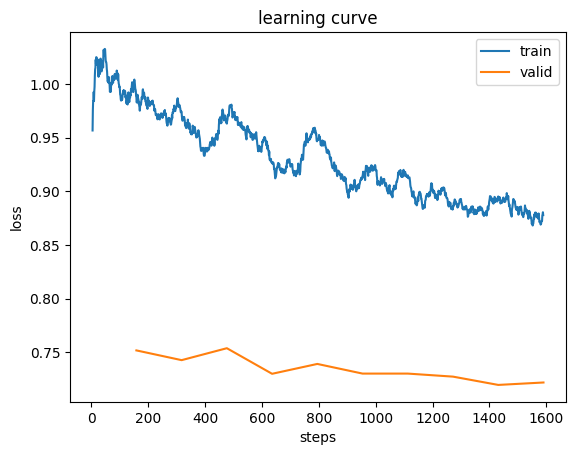

In [7]:
# 📉 Plot combined training and validation loss over epochs
learn.recorder.plot_loss()


In [14]:
from fastai.vision.all import *

# Load the best saved model if needed
# learn = load_learner('/content/drive/MyDrive/cap/convnext_model/export.pkl')

# Create an interpreter from the learner
interp = ClassificationInterpretation.from_learner(learn)


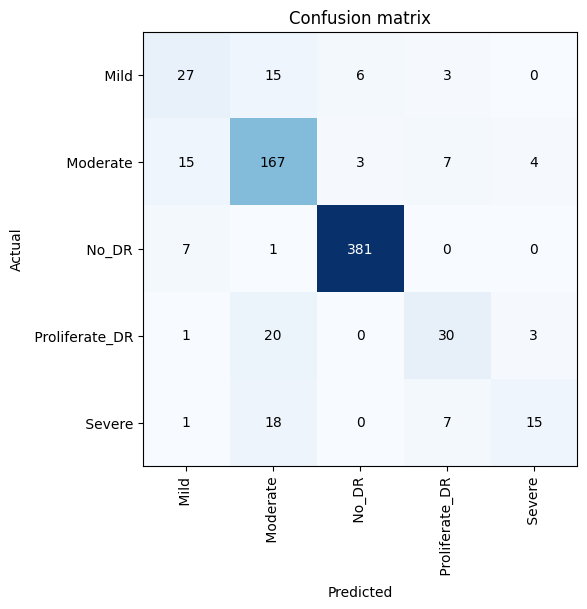

In [15]:
# Basic confusion matrix
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)


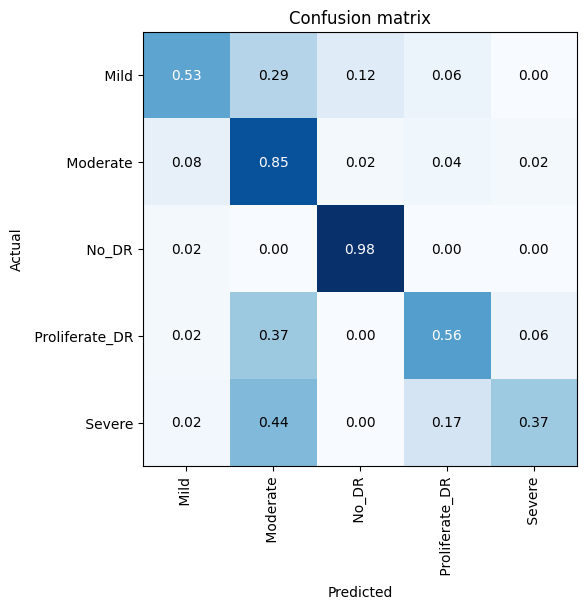

In [16]:
# Normalize by true class count (better for imbalanced datasets)
interp.plot_confusion_matrix(normalize=True, figsize=(6,6), dpi=100)


In [17]:
interp.most_confused(min_val=2)


[(' Proliferate_DR', ' Moderate', np.int64(20)),
 (' Severe', ' Moderate', np.int64(18)),
 (' Mild', ' Moderate', np.int64(15)),
 (' Moderate', ' Mild', np.int64(15)),
 (' Moderate', ' Proliferate_DR', np.int64(7)),
 (' No_DR', ' Mild', np.int64(7)),
 (' Severe', ' Proliferate_DR', np.int64(7)),
 (' Mild', ' No_DR', np.int64(6)),
 (' Moderate', ' Severe', np.int64(4)),
 (' Mild', ' Proliferate_DR', np.int64(3)),
 (' Moderate', ' No_DR', np.int64(3)),
 (' Proliferate_DR', ' Severe', np.int64(3))]

In [18]:
model_path = Path('/content/drive/MyDrive/cap/convnext_model')
model_path.mkdir(parents=True, exist_ok=True)
learn.export(model_path / 'export.pkl')
learn.save(model_path / 'final-stage')


Path('/content/drive/MyDrive/cap/convnext_model/final-stage.pth')

In [10]:
test_dl = learn.dls.test_dl(test_df, with_labels=True)
test_loss, test_acc = learn.validate(dl=test_dl)
print(f"✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 78.33% | Test Loss: 0.8132


🔮 Predicted Class:  Moderate
📊 Probability: 0.7298


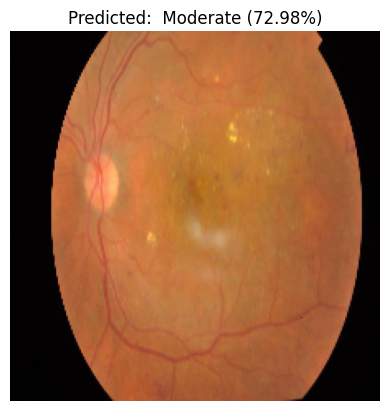

In [20]:
from fastai.vision.all import *

# ✅ Step 1: Load the exported model
learn_inf = load_learner('/content/drive/MyDrive/cap/convnext_model/export.pkl')

# ✅ Step 2: Path to your image
img_path = '/content/drive/MyDrive/cap/test/09eeafa9656a_png.rf.2bd404ec0042cb30c9ce75237434cdc4.jpg'

# ✅ Step 3: Make prediction
pred_class, pred_idx, probs = learn_inf.predict(img_path)

# ✅ Step 4: Print results
print(f"🔮 Predicted Class: {pred_class}")
print(f"📊 Probability: {probs[pred_idx]:.4f}")
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {pred_class} ({probs[pred_idx]*100:.2f}%)')
plt.show()
